In [183]:
from typing import Tuple

import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import pandas as pd
import scipy.stats as st
import numpy as np
from src.get_project_data import housing_data, locale_data
pd.options.mode.chained_assignment = None  # default='warn'  # Hide SettingWithCopyWarning

In [184]:
housing_df = housing_data()
locale_df = locale_data()

In [185]:
# Define list of zip codes for Austin area
_AUSTIN_AREA_ZIP_CODES = [78701, 78702, 78703, 78704, 78705, 78721, 78722, 78723, 78731, 78751, 78752, 78756, 78757, 78758, 78759]

# Filter housing_df by Austin area zip codes
housing_df = housing_df[housing_df['zipcode'].isin(_AUSTIN_AREA_ZIP_CODES)]

# Merge with locale_df
df_full = housing_df.merge(locale_df, how='left', on='zipcode')

# Fill missing values with 0
df_full[['pending_listing_count', 'active_listing_count', 'new_listing_count', 'total_listing_count']] = df_full[['pending_listing_count', 'active_listing_count', 'new_listing_count', 'total_listing_count']].fillna(0)

# Print shape and sample of df_full
print(df_full.shape)
df_full.sample(10)



(1215, 41)


,date,zipcode,zip_name,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,...,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,quality_flag,LOCALE
925,2018-02-01,78701,"austin, tx",746057,0.0953,0.2281,105,-0.0323,-0.0498,89,...,0.0588,0.0414,126,0.0161,-0.0233,0.2095,0.0805,0.0421,0.0,11
668,2019-07-01,78757,"austin, tx",491925,0.0694,0.0384,46,-0.0319,-0.5309,31,...,0.0046,0.0113,85,-0.0659,-0.4637,0.8681,-0.0468,0.2341,0.0,11
252,2021-11-01,78758,"austin, tx",507500,0.0253,0.3611,22,-0.1200,-0.1852,24,...,0.0856,0.3974,48,-0.0204,-0.4783,1.2273,0.2673,-1.2542,1.0,11
759,2019-01-01,78756,"austin, tx",644000,0.1398,0.6264,22,-0.1538,0.3333,62,...,0.0718,0.6880,27,-0.2639,0.2045,0.2045,-0.1801,-0.1288,1.0,11
372,2021-03-01,78704,"austin, tx",849950,0.0002,0.0635,66,0.0233,-0.5525,34,...,-0.0184,0.0530,202,-0.0628,-0.1742,2.0909,-0.3122,1.3960,0.0,11
777,2018-12-01,78721,"austin, tx",399990,0.0322,0.1428,67,-0.0629,0.1754,67,...,0.0377,0.0520,84,-0.0919,-0.0118,0.2836,-0.0171,-0.2076,0.0,11
242,2021-11-01,78757,"austin, tx",699000,-0.0359,0.1582,20,-0.1667,-0.3443,19,...,-0.0693,0.1347,53,-0.0094,-0.4293,1.6250,0.4167,-0.3914,0.0,11
491,2020-07-01,78759,"austin, tx",551496,0.1497,-0.0487,36,0.0441,-0.4409,35,...,0.0664,0.0635,89,0.1266,-0.1759,1.5211,0.1976,0.8440,0.0,11
905,2018-03-01,78702,"austin, tx",429900,0.0748,-0.0447,97,0.0601,-0.1917,50,...,-0.0103,-0.0197,179,-0.0219,-0.1160,0.8557,-0.1443,0.1848,0.0,11
202,2022-02-01,78702,"austin, tx",822648,0.2196,0.7059,20,-0.2593,-0.6040,26,...,0.1271,0.7225,45,-0.1000,-0.6538,1.2750,0.2750,-0.3092,1.0,11


In [186]:
austin_df = df_full[df_full['zipcode'].isin(_AUSTIN_AREA_ZIP_CODES)]
by_month_totals = austin_df.groupby("date")\
                         .agg({"pending_listing_count": "sum",
                               "active_listing_count": "sum",
                               "new_listing_count": "sum",
                               "total_listing_count": "sum"})\
                         .rename(columns={"pending_listing_count": "Pending Totals",
                                          "active_listing_count": "Active Listings Totals",
                                          "new_listing_count": "New Listings Totals",
                                          "total_listing_count": "Total Listings"})
by_month_totals.head()

,Pending Totals,Active Listings Totals,New Listings Totals,Total Listings
date,,,,
2016-07-01,528,1126,600,1665
2016-08-01,497,1148,522,1637
2016-09-01,458,1182,520,1632
2016-10-01,447,1199,532,1652
2016-11-01,453,1157,380,1601


In [187]:
#calculate  the average number of pending listings per month for each year

# Group by year and month
by_year_month = by_month_totals.groupby(pd.Grouper(freq="M")).sum()

# Calculate the yearly average of pending listings
yearly_avg_pending = by_year_month.groupby(by_year_month.index.year).mean()[["Pending Totals"]]

# Rename column to "Avg Pending Listings per Month"
yearly_avg_pending.rename(columns={"Pending Totals": "Avg Pending Listings per Month"}, inplace=True)

# Add a column for the year
yearly_avg_pending["Year"] = yearly_avg_pending.index

# Set the year as the index
yearly_avg_pending.set_index("Year", inplace=True)

# Print the table
print(yearly_avg_pending)



      Avg Pending Listings per Month
Year                                
2016                      461.166667
2017                      496.416667
2018                      500.416667
2019                          508.75
2020                      584.666667
2021                      570.916667
2022                          273.25
2023                      226.333333


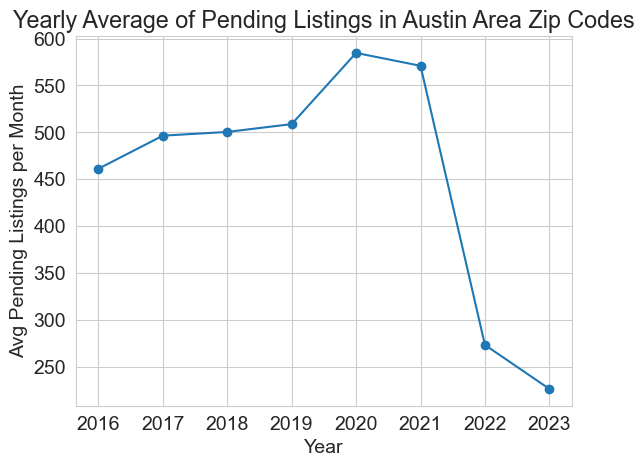

In [188]:
import matplotlib.pyplot as plt

# Create a line plot of the yearly average of pending listings
plt.plot(yearly_avg_pending.index, yearly_avg_pending["Avg Pending Listings per Month"], marker="o")

# Set the title and axis labels
plt.title("Yearly Average of Pending Listings in Austin Area Zip Codes")
plt.xlabel("Year")
plt.ylabel("Avg Pending Listings per Month")

# Show the plot
plt.show()




                                Pre-COVID Avg  Post-COVID Avg   % Change
Avg Pending Listings per Month       491.6875      413.791667 -15.842549


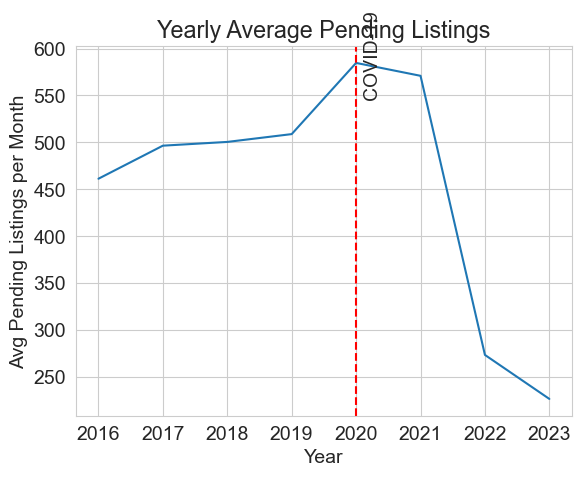

In [189]:
# Split the yearly average pending listings into pre-COVID and post-COVID groups
pre_covid = yearly_avg_pending.loc[:2019]
post_covid = yearly_avg_pending.loc[2020:]

# Calculate the percent change in average pending listings between pre-COVID and post-COVID periods
pct_change = ((post_covid.mean() - pre_covid.mean()) / pre_covid.mean()) * 100

# Create a table to display the results
table = pd.DataFrame({
    "Pre-COVID Avg": pre_covid.mean(),
    "Post-COVID Avg": post_covid.mean(),
    "% Change": pct_change
})

# Print the table
print(table)

# Create a line plot of yearly average pending listings
import matplotlib.pyplot as plt

plt.plot(yearly_avg_pending.index, yearly_avg_pending["Avg Pending Listings per Month"])
plt.title("Yearly Average Pending Listings")
plt.xlabel("Year")
plt.ylabel("Avg Pending Listings per Month")
plt.axvline(x=2020, color='r', linestyle='--')
plt.text(2020.1, 550, "COVID-19", rotation=90)
plt.show()



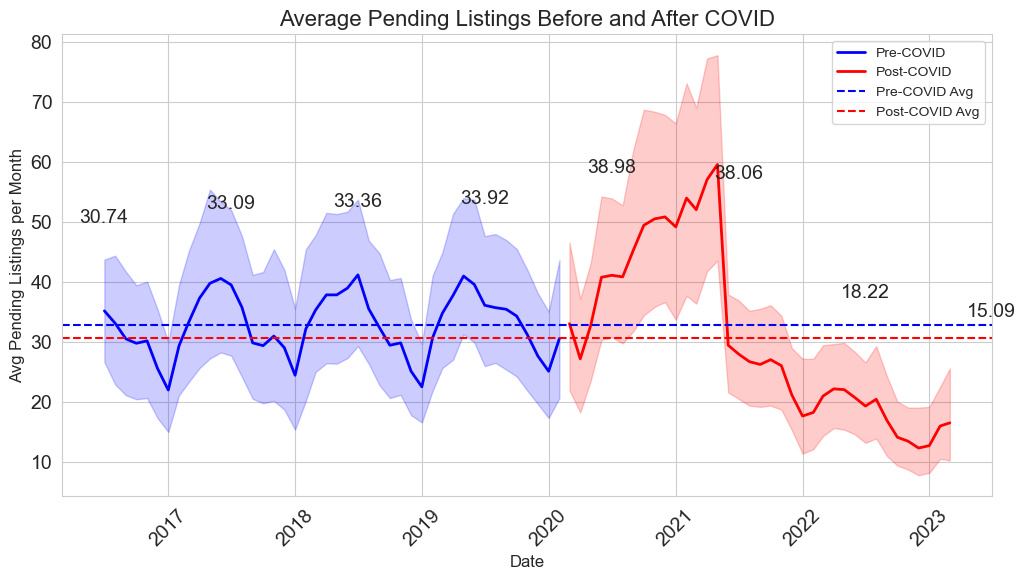

In [190]:
# Calculate pre-COVID and post-COVID averages
df_full['is_covid'] = df_full['date'].apply(lambda x: x >= pd.Timestamp(2020, 3, 1))
pre_covid_avg = df_full.loc[df_full['is_covid'] == False, 'pending_listing_count'].mean()
post_covid_avg = df_full.loc[df_full['is_covid'] == True, 'pending_listing_count'].mean()

# Create pre-COVID and post-COVID data frames
pre_covid_data = df_full.loc[df_full['is_covid'] == False]
post_covid_data = df_full.loc[df_full['is_covid'] == True]

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot pre-COVID data
sns.lineplot(data=pre_covid_data, x='date', y='pending_listing_count', color='blue', label='Pre-COVID', linewidth=2)

# Plot post-COVID data
sns.lineplot(data=post_covid_data, x='date', y='pending_listing_count', color='red', label='Post-COVID', linewidth=2)

# Add horizontal line for pre-COVID average
ax.axhline(pre_covid_avg, ls='--', color='blue', linewidth=1.5, label='Pre-COVID Avg')

# Add horizontal line for post-COVID average
ax.axhline(post_covid_avg, ls='--', color='red', linewidth=1.5, label='Post-COVID Avg')

# Add x-axis and y-axis labels
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Avg Pending Listings per Month', fontsize=12)

# Add yearly average for each year as ylabel
df_yearly_avg = df_full.groupby(df_full['date'].dt.year)['pending_listing_count'].mean()
for year in df_yearly_avg.index:
    ax.text(pd.Timestamp(year, 6, 30), df_yearly_avg[year] + 20, round(df_yearly_avg[year], 2), ha='center', va='center')

# Add plot title
ax.set_title('Average Pending Listings Before and After COVID', fontsize=16)

# Set x-axis tick parameters
ax.tick_params(axis='x', labelrotation=45)

# Set legend parameters
ax.legend(fontsize=10)

# Display plot
plt.show()




